# Прогнозирование оттока клиентов

## Описание проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

##### Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.


###### contract:

    customerID - уникальный идентификатор клиента;
    BeginDate - дата начала пользования услугами;
    EndDate - дата окончания пользования услугами;
    Type - тип оплаты: ежемесячный, годовой и тд;
    PaperlessBilling – безналичный расчет;
    PaymentMethod – способ оплаты;
    MonthlyCharges – ежемесячные траты на услуги;
    TotalCharges – всего потрачено денег на услуги.
    
###### personal:

    customerID - уникальный идентификатор клиента;
    Gender - пол клиента;
    Senior Citizen – наличие пенсионного статуса по возрасту;
    Partner – наличие супруга(и);
    Dependents – наличие иждивенцев.
    
###### internet:
   
    customerID - уникальный идентификатор клиента;
    InternetService - Тип интернет-соединения (оптика, DSL);
    OnlineSecurity - предоставлнение услуги интернет-безопасности;
    OnlineBackup - удаленное резервное копирование данных;
    DeviceProtection - защита устройства;
    TechSupport - техническая поддержка;
    StreamingTV - услуга потоковой трансляции TV;
    StreamingMovies - слуга потоковой трансляции фильмов.
    
###### phone:
    
    customerID - уникальный идентификатор клиента;
    MultipleLines – наличие возможности ведения параллельных линий во время звонка.
    

Информация о договорах актуальна на 1 февраля 2020.

#### План выполнения проекта

1. Загрузка и изучение данных
2. Предобработка данных
3. Обучение моделей
4. Тестирование модели
5. Общий вывод

### Загрузка и изучение данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

Выведем основную информацию о наших данных

In [ ]:
def view_table(data):
    data.columns = data.columns.str.lower()
    display(data.sample(10))
    display(data.info())
    display(data.describe())
    display(data.shape)
    print('Дубликатов:', contract.duplicated().sum())

In [ ]:
view_table(contract)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
6515,7016-BPGEU,2017-05-01,2019-10-01 00:00:00,Month-to-month,Yes,Credit card (automatic),25.10,712.85
2068,9079-LWTFD,2016-03-01,No,Month-to-month,No,Mailed check,100.75,4669.2
2929,2606-PKWJB,2016-10-01,No,One year,No,Mailed check,40.25,1564.05
118,8402-OOOHJ,2016-09-01,No,Two year,No,Mailed check,20.65,835.15
570,7293-LSCDV,2015-02-01,No,Two year,Yes,Credit card (automatic),19.25,1103.25
4764,2962-XPMCQ,2019-11-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,45.15,98.5
3257,5482-VXSXJ,2018-04-01,No,Month-to-month,Yes,Mailed check,93.20,2157.3
1174,6994-ORCWG,2018-12-01,No,One year,Yes,Mailed check,54.25,773.2
2005,9139-WQQDY,2015-10-01,2019-11-01 00:00:00,One year,No,Mailed check,100.45,4941.8
295,8203-XJZRC,2020-01-01,No,Month-to-month,No,Mailed check,20.25,20.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,monthlycharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


(7043, 8)

Дубликатов: 0


In [ ]:
view_table(personal)

,customerid,gender,seniorcitizen,partner,dependents
3989,7634-WSWDB,Female,0,No,Yes
6662,6810-VCAEX,Female,0,No,No
2048,9961-JBNMK,Male,1,No,No
2719,4295-YURET,Female,1,Yes,Yes
6254,9933-QRGTX,Female,0,Yes,No
3277,4323-ELYYB,Male,0,Yes,Yes
2127,8035-BUYVG,Male,0,Yes,No
6098,4700-UBQMV,Male,0,Yes,Yes
271,7633-MVPUY,Male,0,Yes,No
4607,2853-CWQFQ,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,seniorcitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


(7043, 5)

Дубликатов: 0


In [ ]:
view_table(internet)

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
3624,5701-ZIKJE,DSL,No,No,No,Yes,No,No
3147,1329-VHWNP,DSL,No,No,No,No,No,No
2845,3878-AVSOQ,Fiber optic,No,No,No,No,No,No
3021,0365-BZUWY,Fiber optic,No,Yes,Yes,No,Yes,Yes
5213,4186-ZBUEW,DSL,No,Yes,No,Yes,No,Yes
4369,4929-BSTRX,DSL,No,No,No,No,Yes,No
3013,7128-GGCNO,Fiber optic,No,No,No,No,No,No
1352,3280-MRDOF,DSL,No,No,Yes,Yes,Yes,No
61,7410-OIEDU,Fiber optic,Yes,No,Yes,No,No,No
601,8224-IVVPA,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,8868-GAGIO,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


(5517, 8)

Дубликатов: 0


In [ ]:
view_table(phone)

,customerid,multiplelines
15,4190-MFLUW,No
1398,2091-GPPIQ,Yes
6066,4342-HFXWS,No
4946,2506-TNFCO,No
2156,5067-WJEUN,No
469,8397-MVTAZ,Yes
3872,9170-CCKOU,Yes
155,6727-IOTLZ,No
6299,7240-FQLHE,Yes
3839,0307-BCOPK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerid,multiplelines
count,6361,6361
unique,6361,2
top,1097-FSPVW,No
freq,1,3390


(6361, 2)

Дубликатов: 0


Пропусков и дубликатов в данных нет. У столбцов с датой 'BeginDate' и 'EndDate' заменим тип данных. Значение 'NO' в столбце EndDate значит, что клиент являлся обонентом компании на момент выгрузки данных. Столбец 'TotalCharges ' имеет тип данных object, приведем его к типу float64. Столбцы с бинарными данными ('yes' и 'no') заменим на 1 и 0. Для удобства приведем названия столбцов всех датафреймов к нижнему регистру. Объединим все датафреймы в одну таблицу.

### Предобработка данных

Объединим датафреймы в одну таблицу.

In [ ]:
data_full = pd.merge(contract, personal, on ='customerid',how= 'left')
data_full.shape

(7043, 12)

In [ ]:
data_full = pd.merge(data_full, internet, on ='customerid',how= 'left')
data_full.shape

(7043, 19)

In [ ]:
data_full = pd.merge(data_full, phone, on ='customerid',how= 'left')
data_full.shape

(7043, 20)

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


В таблице образовались пропуски. Можно предположить, что абонент не пользовалься данной услугой. Заменим на 'NO'.

In [ ]:
data_full = data_full.fillna('No')
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   7043 non-null   object 
 13  onlinesecurity    7043 non-null   object 
 14  onlinebackup      7043 non-null   object 
 15  deviceprotection  7043 non-null   object 
 16  techsupport       7043 non-null   object 


Создадим новый столбец с целевым признаком 'exited'. Если даты в столбце 'EndDate' нет, то пользователь является клиентом , если дата есть, ушел.

In [ ]:
data_full['exited'] = data_full.apply(lambda x: 0 if x.enddate == 'No' else 1, axis=1)
data_full.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


В процессе работы выяснили, что в столбце 'totalcharges' нет пропусков, но есть пробелы.

In [ ]:
data_full.loc[data_full['totalcharges']==' ']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,exited
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Эти клиенты подключились в день сбора данных. Можно заполнить по этим клиентам значения столбца 'totalcharges' значением 'monthlycharges' или удалить, т.к их очень мало, всего 11 строк. Я их удалю.

In [ ]:
data_full = data_full.loc[data_full['totalcharges']!=' ']

Столбец 'totalcharges' имеет тип данных object, приведём его к типу float64.

In [ ]:
data_full['totalcharges'] = data_full['totalcharges'].astype('float64')

Приведем 'begindate' и 'enddate' к типу 'datetime'.Заполним 'NO' в 'enddate' датой выгрузки и, в новом столбце, посчитаем время, которое клиент являлся абонентом. Удалим 'begindate' и 'enddate'.

In [ ]:
data_full['begindate'] = data_full['begindate'].astype('datetime64')
date = '2020-02-01'
data_full.loc[data_full['enddate'] == 'No', 'enddate'] = date
data_full['enddate'] = data_full['enddate'].astype('datetime64')

In [ ]:
data_full['contract_time']=(data_full['enddate']-data_full['begindate']).dt.days

In [ ]:
data_full = data_full.drop(['enddate', 'begindate','customerid'], axis=1)
data_full.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,exited,contract_time
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,61


Сделаем выборку по ушедшим клиентам

In [ ]:
data_exited = data_full[(data_full['exited']==1)]
data_exited.shape
print(len(data_exited)/len(data_full)*100)

26.578498293515356


Ушло 26,6% клиентов. Это много.

Посмотрим сколько платили ушедшие клиенты

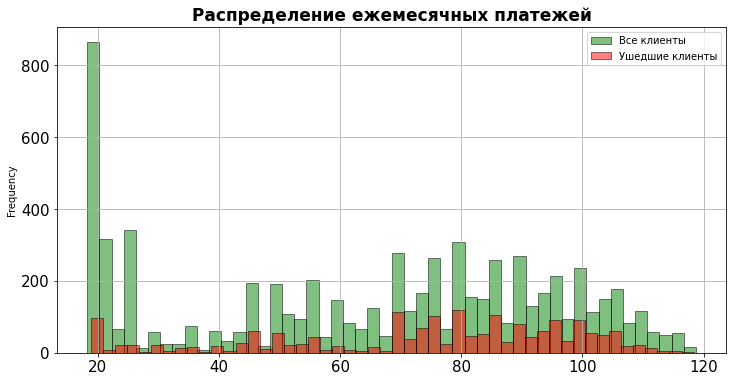

In [ ]:
ax = data_full.plot(kind='hist', y='monthlycharges', ec='black', bins=50, linewidth=1, alpha=0.5, label='Все клиенты', color='g')
data_exited.plot(kind='hist', y='monthlycharges', ec='black', bins=50,linewidth=1, alpha=0.5, label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='r')
ax.set_title('Распределение ежемесячных платежей', fontsize=17, fontweight='bold')
plt.show()

Видно, что много ушедших клиентов с ежемесячным платежем от 70 до 100. Также много клиентов ушло с ежемесячным платежем 20.

Посмотрим на продолжительность контрактов

<AxesSubplot:xlabel='contract_time', ylabel='Density'>

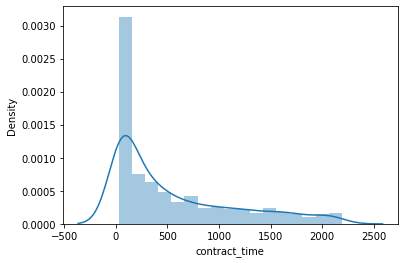

In [ ]:
sns.distplot(data_exited['contract_time'])

<AxesSubplot:xlabel='contract_time', ylabel='Density'>

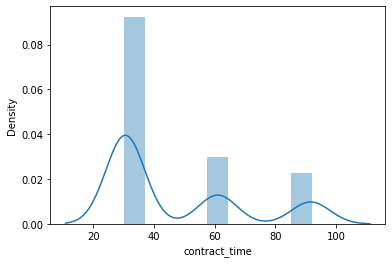

In [ ]:
sns.distplot(data_exited[data_exited['contract_time']<100]['contract_time'])

Видно, что чаще уходят те, кто пользуется услугами 1-2 месяца. Возможно для вновь подключившихся проводятся акции.

Посмотрим на корреляцию числовых признаков

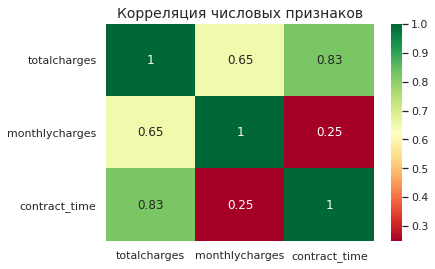

In [ ]:
correlation = data_full[['totalcharges', 'monthlycharges', 'contract_time']]
sns.set(font_scale=1)
sns.heatmap(correlation.corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Сильная корреляция между признакаями 'contract_time' и 'totalcharges'. И средняя между 'totalcharges' и 'monthlycharges'. Удалим 'totalcharges'.

In [ ]:
data_full = data_full.drop(['totalcharges'], axis=1)
data_full.head()

,type,paperlessbilling,paymentmethod,monthlycharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,exited,contract_time
0,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61
3,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,61


В столбцах с бинарными данными заменим 'yes' и 'no' на 1 и 0.

In [ ]:
data_full['multiplelines'] = pd.Series(np.where(data_full['multiplelines'].values == 'Yes', 1, 0),data_full.index)
data_full['dependents'] = pd.Series(np.where(data_full['dependents'].values == 'Yes', 1, 0),data_full.index)
data_full['partner'] = pd.Series(np.where(data_full['partner'].values == 'Yes', 1, 0),data_full.index)
data_full['gender'] = pd.Series(np.where(data_full['gender'].values == 'Female', 1, 0),data_full.index)
data_full['streamingmovies'] = pd.Series(np.where(data_full['streamingmovies'].values == 'Yes', 1, 0),data_full.index)
data_full['streamingtv'] = pd.Series(np.where(data_full['streamingtv'].values == 'Yes', 1, 0),data_full.index)
data_full['techsupport'] = pd.Series(np.where(data_full['techsupport'].values == 'Yes', 1, 0),data_full.index)
data_full['deviceprotection'] = pd.Series(np.where(data_full['deviceprotection'].values == 'Yes', 1, 0),data_full.index)
data_full['onlinebackup'] = pd.Series(np.where(data_full['onlinebackup'].values == 'Yes', 1, 0),data_full.index)
data_full['onlinesecurity'] = pd.Series(np.where(data_full['onlinesecurity'].values == 'Yes', 1, 0),data_full.index)
data_full['paperlessbilling'] = pd.Series(np.where(data_full['paperlessbilling'].values == 'Yes',1,0),data_full.index)
data_full.head()

,type,paperlessbilling,paymentmethod,monthlycharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,exited,contract_time
0,Month-to-month,1,Electronic check,29.85,1,0,1,0,DSL,0,1,0,0,0,0,0,0,31
1,One year,0,Mailed check,56.95,0,0,0,0,DSL,1,0,1,0,0,0,0,0,1036
2,Month-to-month,1,Mailed check,53.85,0,0,0,0,DSL,1,1,0,0,0,0,0,1,61
3,One year,0,Bank transfer (automatic),42.30,0,0,0,0,DSL,1,0,1,1,0,0,0,0,1371
4,Month-to-month,1,Electronic check,70.70,1,0,0,0,Fiber optic,0,0,0,0,0,0,0,1,61


Метод ОНЕ применим для столбцов с более чем 2 призниками

In [ ]:
data_ohe = pd.get_dummies(data_full, columns = ['type', 'internetservice','paymentmethod'], drop_first = True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   paperlessbilling                       7032 non-null   int64  
 1   monthlycharges                         7032 non-null   float64
 2   gender                                 7032 non-null   int64  
 3   seniorcitizen                          7032 non-null   int64  
 4   partner                                7032 non-null   int64  
 5   dependents                             7032 non-null   int64  
 6   onlinesecurity                         7032 non-null   int64  
 7   onlinebackup                           7032 non-null   int64  
 8   deviceprotection                       7032 non-null   int64  
 9   techsupport                            7032 non-null   int64  
 10  streamingtv                            7032 non-null   int64  
 11  stre

### Обучение моделей

Выделим признаки и целевой признак.

In [ ]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

Разобьем датасет на train и test.

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                              test_size = 0.20,
                                                                              random_state = 25072022,
                                                                              stratify = target,
                                                                              shuffle = True)

Теперь масштабируем числовые признаки с помощью StandardScaler.

In [ ]:
numeric = ['monthlycharges', 'contract_time']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#features_train.head()

In [ ]:
print('Размер обучающей выборки: ', features_train.shape)
print('Размер тестовой выборки: ', features_test.shape)

Размер обучающей выборки:  (5625, 21)
Размер тестовой выборки:  (1407, 21)


Функция для кроссвалидации по модели.

In [ ]:
def grid(model, features, target, params):
    roc_auc_scorer=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    grid= GridSearchCV(model, params, scoring=roc_auc_scorer, cv=5, n_jobs = -1)
    grid.fit(features, target)
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)
    print('Лучшая метрика ROC_AUC: {:.3f}'.format(grid.best_score_))

Логистическая регрессия

In [ ]:
%%time
lr_model = LogisticRegression(random_state=25072022)
lr_params = {'class_weight':['balanced',None], 'C':[2, 5,8]}
grid(lr_model, features_train, target_train, lr_params)

Лучшие гиперпараметры для модели:  {'C': 8, 'class_weight': 'balanced'}
Лучшая метрика ROC_AUC: 0.842
CPU times: user 7.85 s, sys: 21.3 s, total: 29.1 s
Wall time: 29 s


Дерево решений

In [ ]:
%%time
tree_model = DecisionTreeClassifier(random_state=25072022)
tree_params = {'max_depth': range(1, 17, 5),'class_weight':['balanced',None]}
grid(tree_model, features_train, target_train, tree_params)

Лучшие гиперпараметры для модели:  {'class_weight': None, 'max_depth': 6}
Лучшая метрика ROC_AUC: 0.849
CPU times: user 688 ms, sys: 68.7 ms, total: 757 ms
Wall time: 786 ms


Случайный лес

In [ ]:
%%time
forest_model = RandomForestClassifier(random_state=25072022)
forest_params={'max_depth': range(1, 13, 2), 'class_weight':['balanced',None], 'n_estimators':range(1,45,5)}
grid(forest_model, features_train, target_train, forest_params)

Лучшие гиперпараметры для модели:  {'class_weight': None, 'max_depth': 7, 'n_estimators': 41}
Лучшая метрика ROC_AUC: 0.857
CPU times: user 35 s, sys: 671 ms, total: 35.6 s
Wall time: 35.7 s


CatBoostClassifier

In [ ]:
%%time
cbc_model = CatBoostClassifier(random_state=25072022, silent=True, loss_function='CrossEntropy')
cbc_params = {'max_depth': [5], 'learning_rate': [0.02], 'n_estimators': [800]}
               
grid(cbc_model, features_train, target_train, cbc_params)

Лучшие гиперпараметры для модели:  {'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 800}
Лучшая метрика ROC_AUC: 0.896
CPU times: user 8.32 s, sys: 430 ms, total: 8.75 s
Wall time: 15.8 s


Лучшая модель 'CatBoostClassifier' ROC_AUC: 0.896

### Тестирование модели

Accuracy: 0.853
AUC-ROC: 0.899
CPU times: user 1.48 s, sys: 98.3 ms, total: 1.58 s
Wall time: 2.58 s


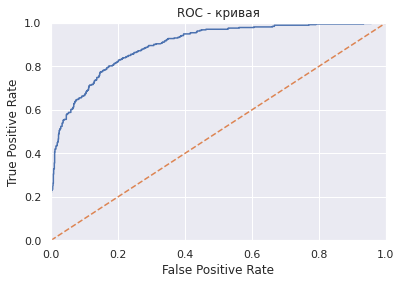

In [ ]:
%%time
cbc_test = CatBoostClassifier(n_estimators=800, silent=True, loss_function='CrossEntropy', 
                        learning_rate=0.02, max_depth=5, random_state=25072022)
cbc_test.fit(features_train, target_train)
predictions_cbc = cbc_test.predict(features_test)
probabilities_test = cbc_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
#plt.legend(loc='lower right', fontsize='x-large')
print('Accuracy: {:.3f}' .format(accuracy_score(target_test, predictions_cbc)))
print('AUC-ROC: {:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))

На тесте AUC-ROC= 0.899 и Accuracy= 0.853.

Посмотрим важность признаков для нашей модели

In [ ]:
feat_import = pd.DataFrame(data = {'feature': features_train.columns, 'percent': cbc_test.feature_importances_})
feat_import.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,contract_time,59.485624
1,monthlycharges,9.066534
2,type_Two year,6.802025
3,internetservice_Fiber optic,3.581131
4,internetservice_No,2.469829
5,paymentmethod_Electronic check,2.176017
6,type_One year,2.151743
7,paperlessbilling,2.073436
8,techsupport,1.714963
9,seniorcitizen,1.162631


<BarContainer object of 21 artists>

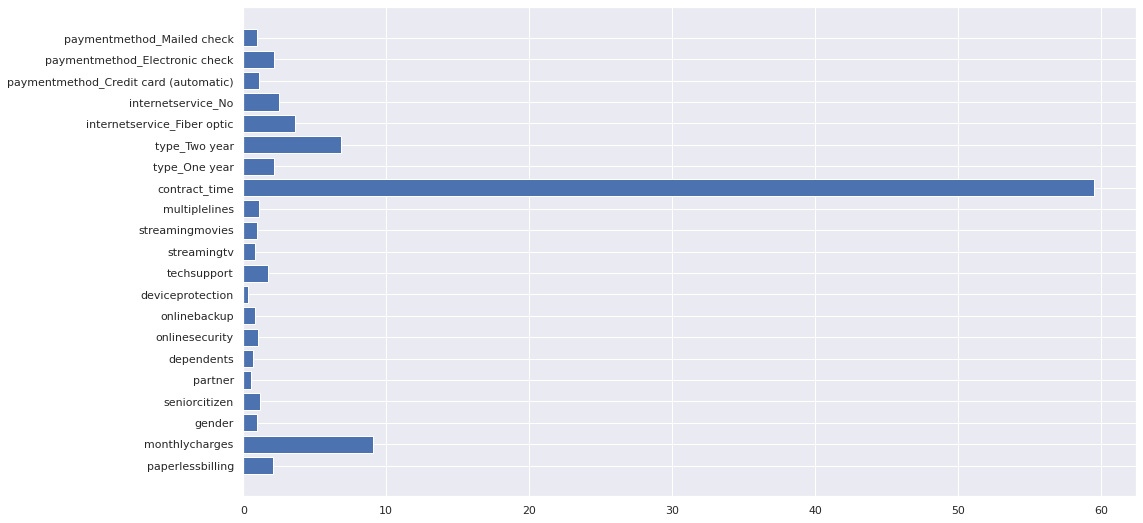

In [ ]:
plt.figure(figsize=(16,9))
feature_import2 = cbc_test.feature_importances_
col_names = features_train.columns
indices = np.argsort(feature_import2)[::-1]
plt.barh(col_names,feature_import2)

Видим, что самый значимый признак, это время пользования услугами.

В итоге получили лучшую модель: CatBoost с roc_auc = 0.899 и точностью в 85%.

### Общий вывод

    Загрузили данные, вывели на экран и изучили основную информацию о датасетах, проверили на пропуски и дубликаты. Наметили дальнейший ход работы.
    
    Объедилили все датасеты в одну таблицу. Пропуски заменили на 'NO', т.к. предположили, что клиент не пользовалься услугой. При соединении таблиц метедом 'join' пропадала часть данных, соединил через 'merge', сразу все получилось.
    
    Добавили столбец с целевым признаком "Ушел клиент или нет".
    
    Удалили строки с прпусками в столбце 'totalcharges', т.к. их было всего 11 строк. Эти строки обнаружил не сразу, только при смене типов столбца. Пришлось выяснять где косяк. Оказалось, что стояли пробелы. 
    
    Создали признак "Длительность контракта".
    
    Построили график ежемесячных платежей по всем и ушедшим клиентам и график продолжительности контрактов. Выяснили, что много ушедших клиентов с ежемесячным платежем от 70 до 100. Также много клиентов ушло с ежемесячным платежем 20 и, что чаще уходят те, кто пользуется услугами 1-2 месяца.
    
    Увидели сильную корреляцию между признаками 'contract_time' и 'totalcharges'и средняю между 'totalcharges' и 'monthlycharges'. Удалили столбец'totalcharges'.
    
    Заменили в столбцах с бинарными данными 'yes' и 'no' на 1 и 0. Применили метод ОНЕ для столбцов с более чем 2 призниками 'type', 'internetservice','paymentmethod'.
    
    Данные разделили на обучающую и тестовую выборки в пропорции 80:20. Отмасштабировали числовые признаки.
    
    Для обучения взяли 3 простые модели 'Логистическая регрессия', 'Дерево решений' и 'Случайный лес' и  модель градиентного бустинга 'CatBoost' и с помощью кроссвалидации нашли оптимальные параметры.
    
    Наилучшей оказалась модель градиентного бустинга 'CatBoost' со значениями ROC_AUC: 0.896. 
    
    На тесте 'CatBoost' показал AUC-ROC= 0.899 и Accuracy= 0.853. Модель можно брать в работу.
    
    Построили ROC-кривую. И график важности признаков для нашей модели. Самым значимым признаком оказалось время пользования услугами.
    
